In [3]:
import sys
sys.path.append("../") # go to parent dir

import jax
import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt
import module.chebyshev_solver as chb

import optax
from tqdm import tqdm

In [4]:
key = jax.random.PRNGKey(0)

## Explore the Loss Landscape in 2D
We parametrise the conductivity k with a guassian of fixed variance, parametrised by its two-dimensional position. Here we plot the loss function for the entire 2D grid of possible position values to find out about the structure of the loss function.

In [5]:
solver = chb.Solver(N = 10) # initialise solver
xx = solver.xx              # this code is equivalent to the code in multi_measurement.ipynb
yy = solver.yy
grid = solver.grid
dims = (solver.N, solver.N)
mask = np.ones(dims)
mask[1:-1,1:-1] = 0
maskx = np.ones(dims)
maskx[:,1:-1] = 0
masky = np.ones(dims)
masky[1:-1,:] = 0
mask = jnp.array(mask)
ii, jj = jnp.meshgrid(jnp.arange(solver.N), jnp.arange(solver.N))
a = 1.4
index_decay = jnp.exp(-(ii+jj)/a)

mu_init = jnp.array([0.5,0.8])  # generate initial conductivity which is a gaussian at this position
sigma = jnp.array(0.6) 
k_init = jnp.exp(-((xx - mu_init[0])**2+(yy - mu_init[1])**2) / sigma) + 0.1
k_cheby_init = solver.invI @ k_init.flatten()

key, _ = jax.random.split(key)

dirichlet_cheby = jax.random.normal(key, shape = dims) * index_decay   # generate only one measurement
dirichlet = (solver.I @ dirichlet_cheby.flatten()).reshape(dims)
dirichlet *= mask

target_solution = solver.solve(k_cheby_init, dirichlet)

#####################
# Helper Functions
#####################

@jax.jit
def get_neumann(solution):
    jx = (solution["dx T"] * solution["k"]).reshape(dims)
    jy = (solution["dy T"] * solution["k"]).reshape(dims)

    neumann = jnp.concatenate((jx[:,0], jy[-1,:], jx[:,-1], jy[0,:]), axis = 0)
    return neumann

@jax.jit
def distance(solution, target_solution):
    neumann = get_neumann(solution)
    target_neumann = get_neumann(target_solution)

    return jnp.sum((neumann- target_neumann)**2)

In [6]:
@jax.jit
def get_k(mu, sigma):
    """
    Parametrisation of the conductivity k.
    """
    k = jnp.exp(-((xx - mu[0])**2+(yy - mu[1])**2) / sigma) + 0.1
    k_cheby = solver.invI @ k.flatten()
    return k_cheby

In [7]:
@jax.jit
def image(mu, sigma):
    """
    Calculate the pixel value of an image.
    """
    return distance(solver.solve(get_k(mu, sigma), dirichlet), target_solution)

In [8]:
####################
# generate image
####################

In [28]:
num = 50 # image resolution

im = np.zeros(shape = (num,num))
for i, x in enumerate(jnp.linspace(-1,1, num)):
    for j, y in enumerate(jnp.linspace(-1,1, num)):
            im[i,j] = image(jnp.array(jnp.array([x, y])), sigma = 0.6)

            if (i*num + j) % 100 == 0:
                print((i*num + j)/ num**2)

0.0
0.15555555555555556
0.17777777777777778
0.35555555555555557
0.5333333333333333
0.5555555555555556
0.7111111111111111
0.7333333333333333
0.9111111111111111
1.0888888888888888
1.1111111111111112
1.2666666666666666
1.288888888888889
1.4666666666666666
1.6444444444444444
1.6666666666666667
1.8222222222222222
1.8444444444444446
2.022222222222222
2.2
2.2222222222222223
2.3777777777777778
2.4
2.577777777777778
2.7555555555555555


In [29]:
### show loss function for different sizes of the gaussian blob

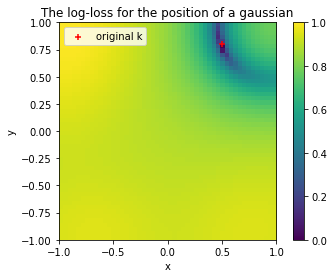

In [30]:
plt.figure()
plt.imshow(jnp.flip(jnp.log(im[:,:]), 1).T, extent = [-1,1,-1,1])
plt.scatter(mu_init[0], mu_init[1], color = "r", label = "original k", marker = "+")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.title("The log-loss for the position of a gaussian")
plt.legend()
plt.savefig("../plot/gaussian.pdf")

---